#Only run the below once at the beginning of a session


In [ ]:
!mkdir ~/.kaggle #create the .kaggle folder in your root directory
!echo '{"username":"jdohea","key":"afcb712412be4ba88eedbbd90c32db9e"}' > ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!pip install kaggle #install the kaggle library
!kaggle datasets download -d grouplens/movielens-20m-dataset -p /content/kaggle/
!unzip kaggle/movielens-20m-dataset.zip -d kaggle
!kaggle datasets download -d jrobischon/wikipedia-movie-plots -p /content/kaggle/
!unzip kaggle/wikipedia-movie-plots.zip -d kaggle
!pip install lenskit
!pip install nltk
data_path ="kaggle"

 93% 181M/195M [00:01<00:00, 122MB/s]
100% 195M/195M [00:01<00:00, 123MB/s]
Archive:  kaggle/movielens-20m-dataset.zip
  inflating: kaggle/genome_scores.csv  
  inflating: kaggle/genome_tags.csv  
  inflating: kaggle/link.csv         
  inflating: kaggle/movie.csv        
  inflating: kaggle/rating.csv       
  inflating: kaggle/tag.csv          
 57% 17.0M/29.9M [00:00<00:00, 46.7MB/s]
100% 29.9M/29.9M [00:00<00:00, 75.6MB/s]
Archive:  kaggle/wikipedia-movie-plots.zip
  inflating: kaggle/wiki_movie_plots_deduped.csv  
     |████████████████████████████████| 87 kB 3.3 MB/s 
     |████████████████████████████████| 256 kB 19.1 MB/s 


In [ ]:
import pandas as pd
import seaborn as sns
from lenskit.algorithms import Recommender
from lenskit.algorithms.user_knn import UserUser
from lenskit.algorithms import Recommender
from lenskit.algorithms.user_knn import UserUser
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sp
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sp
from sklearn.metrics import mean_absolute_error
import statistics
from sklearn.metrics import mean_squared_error
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from scipy import stats
from IPython.utils import io
import itertools
import matplotlib.pyplot as plt

nltk.download('wordnet')
nltk.download('punkt')
 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Helper methods

In [70]:
def select_a_user(ratings_df):
  users_ratings = ratings_df.groupby(['user']).count()
  # selected = users_ratings['rating'] > 200
  # selected_users = users_ratings.loc[selected]
  random_selected = users_ratings.sample() # sample() returns a random row from the dataframe. The returned object is a dataframe with one row. If you pass a number as argument you specify to select more than one row.
  select_column_df = random_selected.reset_index()['user'] # reset_index() create a new index, and the user became a column. Then, we can filter using the column name
  selected_user = select_column_df.iloc[0] # iloc select by index, since our dataframe only has one row we read it from the index 
  return selected_user

#The following method returns a datafram with the all the movies that a user rated and the movies features.
#There is one dataframe for the movies where the user has rated the movies, this contains the ratings as an extra feature
#another dataframe with all the movies the user has not rated 
def get_user_rated_and_unrated_movies(selected_user, ratings_df, movies_df):
  #Retrieving the information of the rated and unrated movies for the selected user
  selected_user_ratings = ratings_df.loc[ratings_df['user'] == selected_user]
  selected_user_ratings = selected_user_ratings.sort_values(by='item', ascending=True)
  rated_movies_df = movies_df.loc[list(selected_user_ratings['item'])]
  #We use a similar approach to select the unrated movies
  diff = set(movies_df.index) - set(rated_movies_df.index)
  unrated_movies_df = movies_df.loc[diff]
  rated_movies_df.drop(['item'], axis = 1, inplace = True) 
  rated_movies_df = rated_movies_df.join(selected_user_ratings.set_index('item')['rating'], on='item')
  return (rated_movies_df , unrated_movies_df)

def select_muliple_users(ratings_df, n):
  users_ratings = ratings_df.groupby(['user']).count()
  # selected = users_ratings['rating'] > 10
  # selected_users = users_ratings.loc[selected]
  random_selected = users_ratings.sample(n) # sample() returns a random row from the dataframe. The returned object is a dataframe with one row. If you pass a number as argument you specify to select more than one row.
  select_column_df = random_selected.reset_index()['user'] # reset_index() create a new index, and the user became a column. Then, we can filter using the column name
  return select_column_df

In [ ]:

#This method returns a join of movies to the ratings on the item number,
#so for every rating that a user gives a movie we have the data about the movie also.
def get_ratings_with_movie_details(ratings_df, movies_df):
    tmp_movies_df=movies_df.drop(columns=['item'])
    return ratings_df.merge(tmp_movies_df, on='item', how='inner')



#This method returns the list of integers, the index of a frequency in the returned matrix corresponds
#to the 'unique_genres' indices of genres
def get_frequencies_of_ratings_per_genre(dataframe_of_ratings, movies_df):
    movies_and_ratings = get_ratings_with_movie_details(dataframe_of_ratings, movies_df);
    listOfLists_genre = [[]for i in range(len(unique_genres))]

    for index,row in movies_and_ratings.iterrows():
          for genre in unique_genres:
            if genre in row['genres']:
                  listOfLists_genre[unique_genres.index(genre)].append(1)

    genre_frequencies = []
    for i in range(len(listOfLists_genre)):
          genre_frequencies.append(len(listOfLists_genre[i]))
    
    return genre_frequencies

#Data loading & preparation:

To make sure our algorithms compile, we need to test the recommendations on a user. To do such thing we select a random user.
For simplicity, we select a random user from the ratings_df Dataframe having more than 100 evaluations.

In [ ]:
ratings_df = pd.read_csv(data_path+"/rating.csv") 
ratings_df.rename(columns={'userId': 'user',
                   'movieId': 'item'},
          inplace=True, errors='raise')


movies_df = pd.read_csv(data_path+"/movie.csv")
movies_df.rename(columns={'movieId': 'item'},
          inplace=True, errors='raise')
movies_df.index = movies_df['item']
movies_df = movies_df.drop_duplicates(subset='item', keep='first') #we make sure there are no duplicates in the dataset

unique_genres = ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical', 'Western', 'Film-Noir']

display(ratings_df.head(3))
display(movies_df.head(3))

,user,item,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39


,item,title,genres
item,,,
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,2,Jumanji (1995),Adventure|Children|Fantasy
3,3,Grumpier Old Men (1995),Comedy|Romance


###For Collaborative filtering and evaluation we need to extract a subset of the dataset so we can run the algorithms in a reasonable time. To do this we:



1.   explore the distribution of ratings over time
2.   take the most recent % of ratings, for e.g. 30% (0.3)
3.   take a random sample of % or ratings for comparison with the most recent sample of ratings






In [ ]:
ratings_df = ratings_df.sort_values(by=['timestamp'],ignore_index=True)
ratings_df['year_of_rating_timestamp'] = pd.to_datetime(ratings_df['timestamp']).dt.to_period('Y')
percentage_of_ratings = 0.2
num_rows = ratings_df.shape[0]
subset_ratings_df_recent = ratings_df[int(num_rows*(1.0-percentage_of_ratings)):num_rows]
subset_ratings_df_recent = subset_ratings_df_recent.reset_index(drop=True)
## VS taking a random sample of 30% perhaps? ##possible comparison to be made here
subset_ratings_df_random = ratings_df.sample(n=int(num_rows*percentage_of_ratings),replace=False)
subset_ratings_df_random =subset_ratings_df_random.reset_index(drop=True)

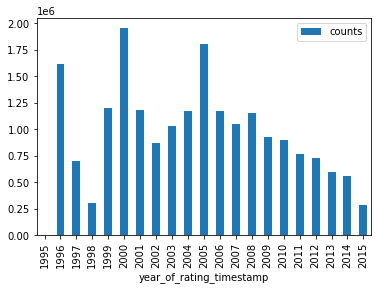

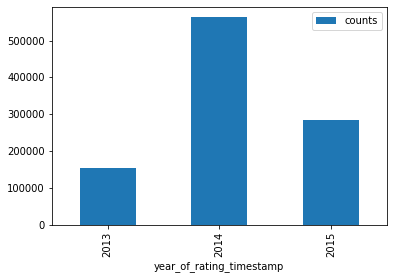

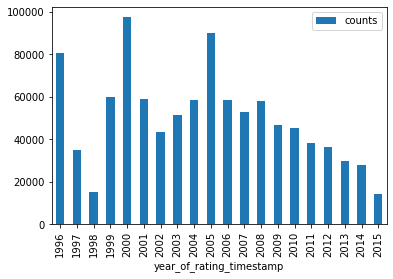

In [ ]:
gp = ratings_df.groupby('year_of_rating_timestamp').size().reset_index(name='counts')
gp.plot(kind='bar',x='year_of_rating_timestamp', y ='counts')

gp = subset_ratings_df_recent.groupby('year_of_rating_timestamp').size().reset_index(name='counts')
gp.plot(kind='bar',x='year_of_rating_timestamp', y ='counts')

gp = subset_ratings_df_random.groupby('year_of_rating_timestamp').size().reset_index(name='counts')
gp.plot(kind='bar',x='year_of_rating_timestamp', y ='counts')


#Data exploration

Let´s see how often each rating occurs for the whole data set:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 5 columns):
 #   Column                    Dtype        
---  ------                    -----        
 0   user                      int64        
 1   item                      int64        
 2   rating                    float64      
 3   timestamp                 object       
 4   year_of_rating_timestamp  period[A-DEC]
dtypes: float64(1), int64(2), object(1), period[A-DEC](1)
memory usage: 762.9+ MB
None
number of users:  138493
number of movies:  26744

study of ratings
count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


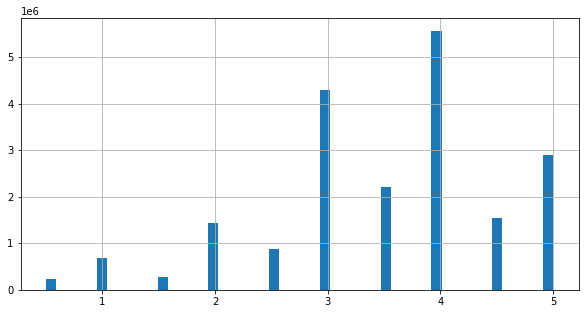

In [ ]:
ratings_df['rating'].hist(bins = 50, figsize=(10, 5))
print(ratings_df.info())
print('number of users: ',len(ratings_df["user"].unique()))
print('number of movies: ', len(ratings_df["item"].unique()))
print()
print('study of ratings')
print(ratings_df.describe()['rating'])

Let´s see how often each rating occurs for the recent subset data set:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000014 entries, 0 to 1000013
Data columns (total 5 columns):
 #   Column                    Non-Null Count    Dtype        
---  ------                    --------------    -----        
 0   user                      1000014 non-null  int64        
 1   item                      1000014 non-null  int64        
 2   rating                    1000014 non-null  float64      
 3   timestamp                 1000014 non-null  object       
 4   year_of_rating_timestamp  1000014 non-null  period[A-DEC]
dtypes: float64(1), int64(2), object(1), period[A-DEC](1)
memory usage: 38.1+ MB
None
number of users:  10715
number of movies:  21359

study of ratings
count    1.000014e+06
mean     3.586841e+00
std      1.037756e+00
min      5.000000e-01
25%      3.000000e+00
50%      4.000000e+00
75%      4.500000e+00
max      5.000000e+00
Name: rating, dtype: float64


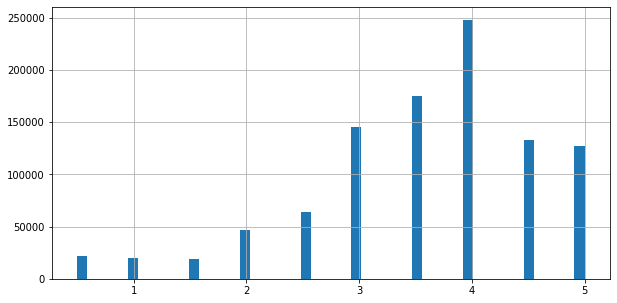

In [ ]:
subset_ratings_df_recent['rating'].hist(bins = 50, figsize=(10, 5))
print(subset_ratings_df_recent.info())
print('number of users: ',len(subset_ratings_df_recent["user"].unique()))
print('number of movies: ', len(subset_ratings_df_recent["item"].unique()))
print()
print('study of ratings')
print(subset_ratings_df_recent.describe()['rating'])

Let´s see how often each rating occurs for the random subset data set:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000013 entries, 0 to 1000012
Data columns (total 5 columns):
 #   Column                    Non-Null Count    Dtype        
---  ------                    --------------    -----        
 0   user                      1000013 non-null  int64        
 1   item                      1000013 non-null  int64        
 2   rating                    1000013 non-null  float64      
 3   timestamp                 1000013 non-null  object       
 4   year_of_rating_timestamp  1000013 non-null  period[A-DEC]
dtypes: float64(1), int64(2), object(1), period[A-DEC](1)
memory usage: 38.1+ MB
None
number of users:  125464
number of movies:  15329

study of ratings
count    1.000013e+06
mean     3.525783e+00
std      1.051725e+00
min      5.000000e-01
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


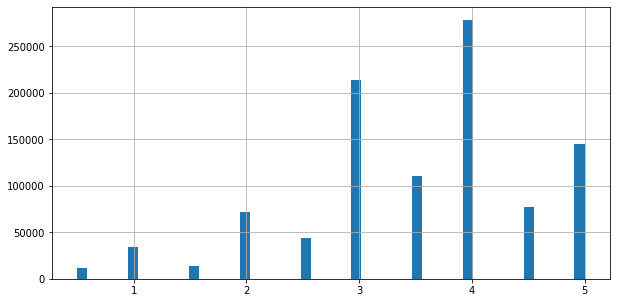

In [ ]:
subset_ratings_df_random['rating'].hist(bins = 50, figsize=(10, 5))
print(subset_ratings_df_random.info())
print('number of users: ',len(subset_ratings_df_random["user"].unique()))
print('number of movies: ', len(subset_ratings_df_random["item"].unique()))
print()
print('study of ratings')
print(subset_ratings_df_random.describe()['rating'])

### Visualization of the distribution of the number of unique user evaluations for each movie.

We want to visuaize instead on the horizontal axe the movies, and on the vertical axe the number of users who evaluated it.

In [ ]:
count_ratings_df = ratings_df[['user','item']].groupby(['item']).count()
count_subset_ratings_df_recent = subset_ratings_df_recent[['user','item']].groupby(['item']).count()
count_subset_ratings_df_random = subset_ratings_df_random[['user','item']].groupby(['item']).count()

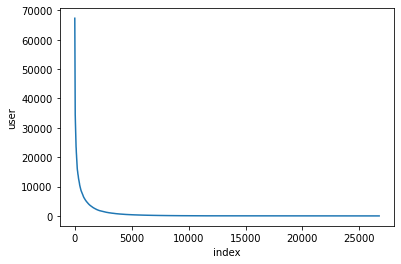

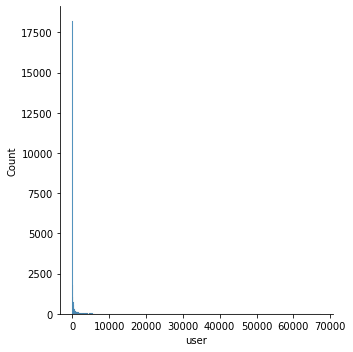

In [ ]:
count_ratings_df_ord = count_ratings_df.sort_values(by="user", ascending=False).reset_index().reset_index()
count_subset_ratings_df_random_ord  = count_subset_ratings_df_random.sort_values(by="user", ascending=False).reset_index().reset_index()
count_subset_ratings_df_recent_ord  = count_subset_ratings_df_recent.sort_values(by="user", ascending=False).reset_index().reset_index()
# display(count_ratings_df_ord)
# display(count_subset_ratings_df_random_ord)
# display(count_subset_ratings_df_recent_ord)
sns.lineplot(data=count_ratings_df_ord, x='index', y='user')
sns.displot(data=count_ratings_df_ord, x='user', binwidth=100)


Now for the random subset of user ratings

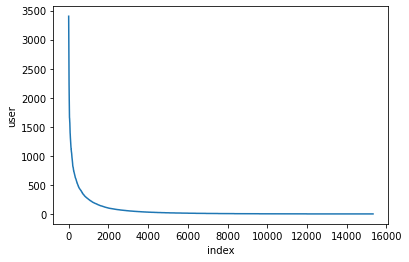

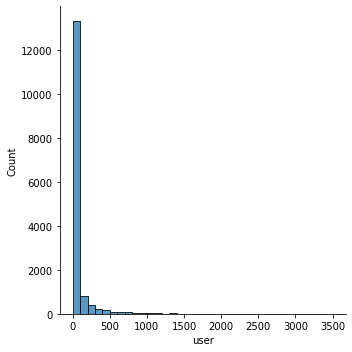

In [ ]:
sns.lineplot(data=count_subset_ratings_df_random_ord, x='index', y='user')
sns.displot(data=count_subset_ratings_df_random_ord, x='user', binwidth=100)


Now for the subset of ratings where we filtered for the most recent ratings

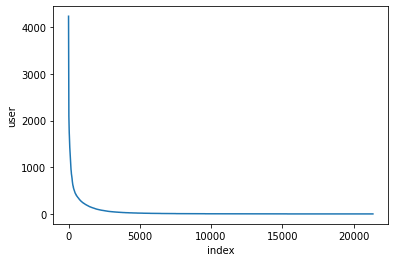

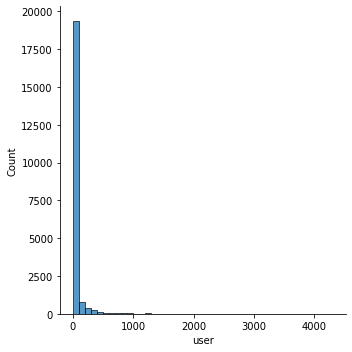

In [ ]:
sns.lineplot(data=count_subset_ratings_df_recent_ord, x='index', y='user')
sns.displot(data=count_subset_ratings_df_recent, x='user', binwidth=100)

To test if the subset distributions come from the distribution we should apply the two sample KS test:

In [76]:
# genre_frequencies_ratings_df=get_frequencies_of_ratings_per_genre(ratings_df,movies_df);
genre_frequencies_recent_df=get_frequencies_of_ratings_per_genre(subset_ratings_df_recent,movies_df);
genre_frequencies_random_df= get_frequencies_of_ratings_per_genre(subset_ratings_df_random,movies_df);
display(stats.ks_2samp(genre_frequencies_recent_df, genre_frequencies_random_df))

Ks_2sampResult(statistic=0.15789473684210525, pvalue=0.978077940445305)

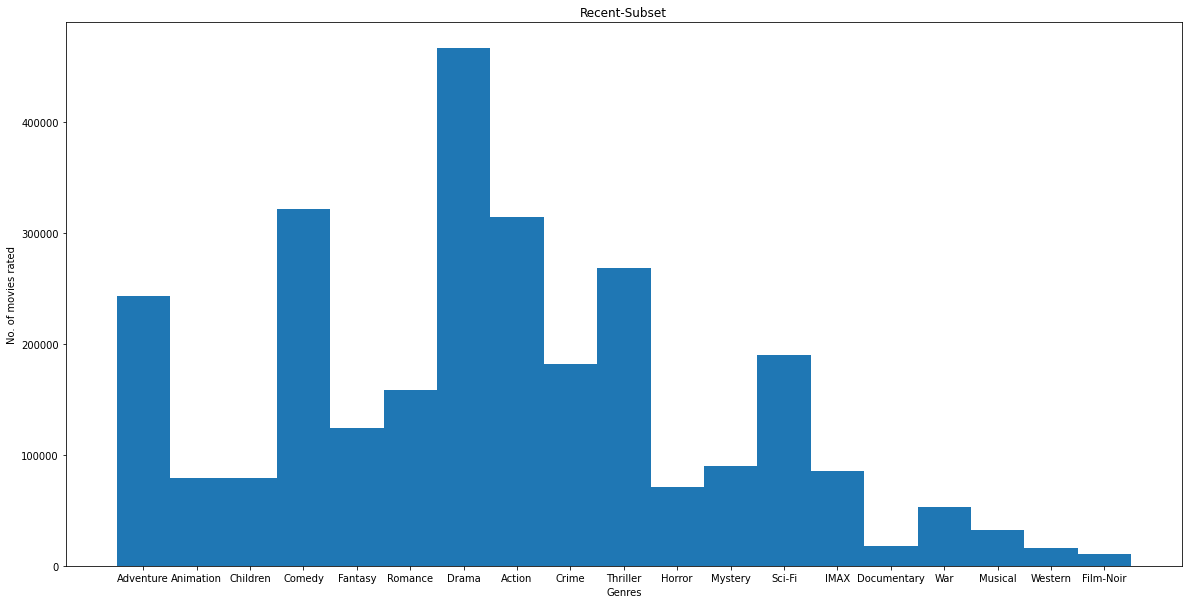

In [ ]:
fig = plt.figure(figsize = (20, 10)) 
  
# creating the bar plot 
plt.bar(unique_genres, genre_frequencies_recent_df,   
        width = 1) 
  
plt.xlabel("Genres") 
plt.ylabel("No. of movies rated") 
plt.title("Recent-Subset") 
plt.show() 
# display(stats.ks_2samp(genre_frequencies_recent_df, genre_frequencies_all))

In [ ]:
fig = plt.figure(figsize = (20, 10)) 
  
# creating the bar plot 
plt.bar(unique_genres, genre_frequencies_random_df,   
        width = 1) 
  
plt.xlabel("Genres") 
plt.ylabel("No. of movies rated") 
plt.title("Random-Subset") 
plt.show() 

# Collaborative Algorithms

### Collaborative user-user recommender with Lenskit

We use the collaborative user algorithm UserUser, that uses the nearest neighbors algorithm. The constructor takes as inputs the maximum and minumum number of neighbors to consider (we set them to 15 and 3). Then we use the adapt method of the Recommender class, to obtain a Recommender object. Then, we can use the fit method to train the model.

In [ ]:
# We use the collaborative user algorithm UserUser, that use the nearest neighbors 
num_recs = 1  # Number of recommendations to generate
user_user = UserUser(15, min_nbrs=2)  # Minimum (3) and maximum (15) number of neighbors to consider
recsys = Recommender.adapt(user_user)
recsys.fit(subset_ratings_df_recent)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
Numba is using threading layer omp - consider TBB
BLAS using multiple threads - can cause oversubscription
found 2 potential runtime problems - see https://boi.st/lkpy-perf


Now, we can provide the recommendations for a specific user. Let's generate 10 recommendations for the user selected for the previous example. We use the recommend method of the Recommender class to generate the recommendations. Then, we add the title information and display the recommendations.

In [ ]:
selected_user = select_a_user(ratings_df=ratings_df)#full ratings
selected_movies_useruser = recsys.recommend(selected_user, 10) # generate 10 recommendations for the selected user 
selected_movies_useruser = selected_movies_useruser.join(movies_df['title'], on='item')
display(selected_movies_useruser)

user 31720 has no ratings and none provided


,item,score,title


In [ ]:
display(subset_ratings_df_recent)

,user,item,rating,timestamp,year_of_rating_timestamp
0,72956,90717,3.0,2013-09-08 23:30:17,2013
1,109796,832,3.0,2013-09-08 23:30:18,2013
2,109796,2699,2.5,2013-09-08 23:30:23,2013
3,17707,318,5.0,2013-09-08 23:30:26,2013
4,109796,160,1.5,2013-09-08 23:30:27,2013
...,...,...,...,...,...
1000009,53930,118706,3.5,2015-03-31 06:00:51,2015
1000010,16978,2093,3.5,2015-03-31 06:03:17,2015
1000011,89081,55232,3.5,2015-03-31 06:11:26,2015
1000012,89081,52458,4.0,2015-03-31 06:11:28,2015


###Evaluation of Collaborative algorithm

In [ ]:

##choose a prepared subset from the data preparation section above
df_to_evaluate = subset_ratings_df_recent #can also be subset_ratings_df_random ... random subset vs most recent ratings subset

kf = KFold(n_splits=5) # Initialize a Kfold object specifying the number K of folds
mean_absolute_error_list_CF = list();
mean_squared_error_list_CF = list();
napolean_dynamite_df = pd.DataFrame();
# Iterate over the folds
for train_index, test_index in kf.split(df_to_evaluate):

    # Filter the train and test sets using the provided positional indexes
    train_df = df_to_evaluate.iloc[train_index]
    test_df = df_to_evaluate.iloc[test_index]
    
    # Train a useruser recommender system
    user_user = UserUser(15, min_nbrs=3)  # Minimum (3) and maximum (15) number of neighbors to consider
    recsys = Recommender.adapt(user_user)
    recsys.fit(train_df)

    # Predict the ratings for the items in the test setfrom IPython.utils import io
    with io.capture_output() as captured: ##this is just to stop the recsys.predict from printing everytime there is a user with no ratings assigned
      test_df['predicted_rating'] = recsys.predict(test_df)

      # compute relevance for he real and the predicted ratings in the test set
      test_df.dropna(inplace=True) ##about half of our users have no values at all since we made a subset so we have remove their NAs for the evaluation
      y_test = test_df['rating'].apply(lambda x: x if x>0 else 0)  #doing this in case of Nan values
      y_pred = test_df['predicted_rating'].apply(lambda x: x if x>0 else 0)
      # y_test = list(test_df['rating'])
      # y_pred = list(test_df['predicted_rating'])


      mean_absolute_error_list_CF.append(mean_absolute_error(y_test, y_pred))
      mean_squared_error_list_CF.append(mean_squared_error(y_test, y_pred))
      
      ##napolean dynamite 
      napolean_dynamite_df = pd.concat([napolean_dynamite_df,test_df])
    
# Compute average results and standard deviations
results = {'avg_mean_abs_error' : statistics.mean(mean_absolute_error_list_CF),'avg_mean_squared_error' : statistics.mean(mean_squared_error_list_CF)}

display(results)

{'avg_mean_abs_error': 0.6540946110087287,
 'avg_mean_squared_error': 0.7564091646217974}

In [ ]:
display(napolean_dynamite_df.head(5))

,user,item,rating,timestamp,year_of_rating_timestamp,predicted_rating
0,72956,90717,3.0,2013-09-08 23:30:17,2013,2.935057
48,31712,58293,1.0,2013-09-08 23:33:20,2013,1.912113
95,36394,98532,3.0,2013-09-08 23:43:18,2013,3.124556
98,70412,60950,4.0,2013-09-08 23:45:12,2013,3.982992
103,35910,8533,3.5,2013-09-08 23:49:52,2013,3.577984


In [ ]:
# display(napolean_dynamite_analysis)
# all = np.vstack(napolean_dynamite_analysis) 
# #We can then look to see if there is a genre that is our napolean dynamite 
# napolean_dynamite_df = pd.DataFrame(all, index=None, columns = ['title', 'genres', 'tags', 'year', 'year norm','y_test', 'y_pred'])
napolean_dynamite_df['difference'] = abs(napolean_dynamite_df['rating']- napolean_dynamite_df['predicted_rating'])
napolean_dynamite_df = napolean_dynamite_df.loc[napolean_dynamite_df['difference']>0.5]


In [ ]:
genre_frequencies_user_CF= get_frequencies_of_ratings_per_genre(napolean_dynamite_df,movies_df);
display(stats.ks_2samp(genre_frequencies_user_CF, genre_frequencies_recent_df))

Ks_2sampResult(statistic=0.6842105263157895, pvalue=0.00015621221647240893)

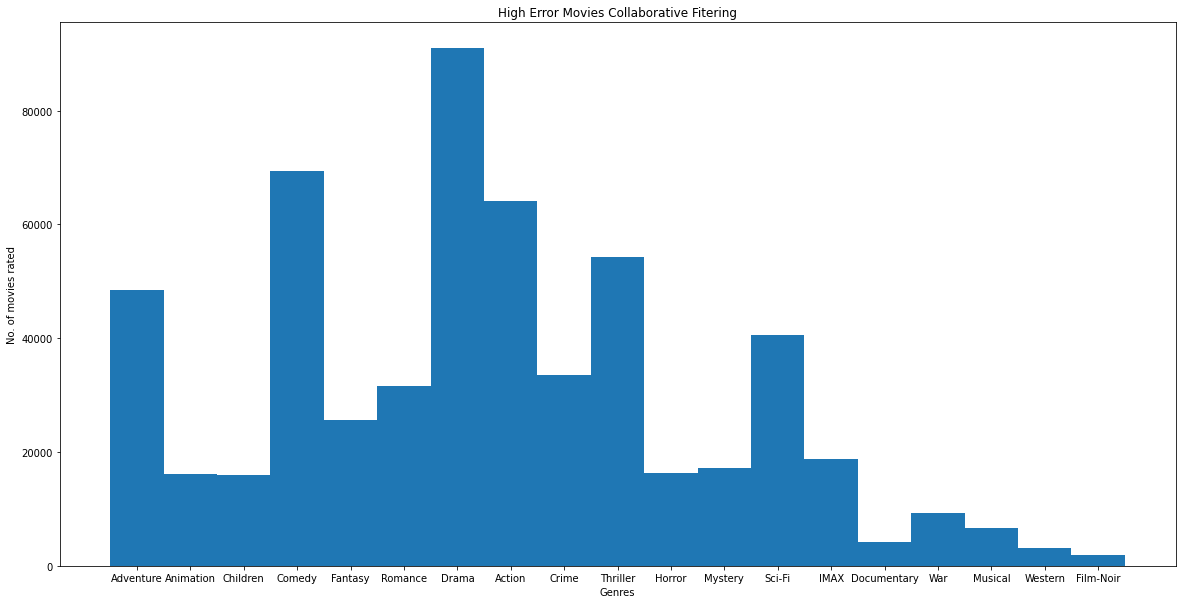

In [ ]:
fig = plt.figure(figsize = (20, 10)) 
  
# creating the bar plot 
plt.bar(unique_genres, genre_frequencies_user_CF,   
        width = 1) 
  
plt.xlabel("Genres") 
plt.ylabel("No. of movies rated") 
plt.title("High Error Movies Collaborative Fitering") 
plt.show()

# Content based algorithm


Now, we need to select the user evaluations, that we will use to train our recommender. We print the number of ratings that we have for the considered user, and the extracted dataset, ordered by ratings.

**Can we use Genre information?**
We make efforts to use genre information in our algorithm. To do so we first need to clean data, we should aware that there are certain items that have no genres assigned to it.

**Getting genres from movies**
We will create a new dataframe in

In [ ]:
genres = movies_df['genres']
without_genre=[]
for i, row in movies_df.iterrows():
  
  genres = row.genres
  genres = genres.split('|')
  for genre in genres:
    if len(genre.split())>1:
      without_genre.append(row.item)
      #print(row)
print('Number of movies with no genres: ', len(without_genre))


Number of movies with no genres:  246


In [ ]:
#There are 246 movies with no genres. It is not thaaaat many compared to the total number of movies, but it is still significant
#I will replace all appearences of 'no genre by nothing
def format_genre_row(genres_row):
  #converts '|' to spaces and converts 'no genres listed' to ''
  if genres_row=='(no genres listed)':
    return ''
  genres= genres_row.split('|')
  string_genres=''
  #print(genres)
  for genre in genres:
      string_genres+=genre+' '
    
  return string_genres

movies_df['genres'] = movies_df['genres'].apply(lambda x: format_genre_row(x))
print(movies_df.head())

      item  ...                                        genres
item        ...                                              
1        1  ...  Adventure Animation Children Comedy Fantasy 
2        2  ...                   Adventure Children Fantasy 
3        3  ...                               Comedy Romance 
4        4  ...                         Comedy Drama Romance 
5        5  ...                                       Comedy 

[5 rows x 3 columns]


### Can we use tags ? (this was not in the lab)

Besides the plots, we have tags for each movie out there. 
We need to inspect whether we have enough data to make a recommendation algorithm using it. 
We need to explore how sparse this data is, how many tags there are for each movie.

In [ ]:
tags_df = pd.read_csv(data_path+"/tag.csv")

print(tags_df[-5:])
tags_df.rename(columns={'userId': 'user',
                   'movieId': 'item'},
          inplace=True, errors='raise')

print(tags_df[-5:])

        userId  movieId            tag            timestamp
465559  138446    55999        dragged  2013-01-23 23:29:32
465560  138446    55999  Jason Bateman  2013-01-23 23:29:38
465561  138446    55999         quirky  2013-01-23 23:29:38
465562  138446    55999            sad  2013-01-23 23:29:32
465563  138472      923  rise to power  2007-11-02 21:12:47
          user   item            tag            timestamp
465559  138446  55999        dragged  2013-01-23 23:29:32
465560  138446  55999  Jason Bateman  2013-01-23 23:29:38
465561  138446  55999         quirky  2013-01-23 23:29:38
465562  138446  55999            sad  2013-01-23 23:29:32
465563  138472    923  rise to power  2007-11-02 21:12:47


In [ ]:
print(tags_df.head())
print(tags_df.info())


   user  item            tag            timestamp
0    18  4141    Mark Waters  2009-04-24 18:19:40
1    65   208      dark hero  2013-05-10 01:41:18
2    65   353      dark hero  2013-05-10 01:41:19
3    65   521  noir thriller  2013-05-10 01:39:43
4    65   592      dark hero  2013-05-10 01:41:18
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465564 entries, 0 to 465563
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user       465564 non-null  int64 
 1   item       465564 non-null  int64 
 2   tag        465548 non-null  object
 3   timestamp  465564 non-null  object
dtypes: int64(2), object(2)
memory usage: 14.2+ MB
None


Let´s see how many tags are in our dataset

In [ ]:
print(len(tags_df['tag'].unique()))

38644


Ok, so we know some tags have been assigned to more than one movie, let´s compute the sparsity of the tag feature.
We compute how many times a tag has been assigned to any item.
We again see that we have a long tail-shor tail structure

In [ ]:

count_items_per_tag_df = tags_df[['tag','item']].groupby(['tag']).count()
print('Mean:', count_items_per_tag_df.mean())
print('Variance: ', count_items_per_tag_df.var())
count_items_per_tag_df = count_items_per_tag_df.sort_values(by="item", ascending=False).reset_index()
print(count_items_per_tag_df.head())
#print(list(count_tags_df.index))
display(count_items_per_tag_df)
#sns.displot(data=count_items_per_tag_df, x=list(count_items_per_tag_df['tag']), y='item')

Mean: item    12.047408
dtype: float64
Variance:  item    5658.957796
dtype: float64
               tag  item
0           sci-fi  3384
1  based on a book  3281
2      atmospheric  2917
3           comedy  2779
4           action  2657


,tag,item
0,sci-fi,3384
1,based on a book,3281
2,atmospheric,2917
3,comedy,2779
4,action,2657
...,...,...
38638,Toby Jones,1
38639,Tobacco Industry,1
38640,Toa Fraser,1
38641,To see with Rachel,1


We inspect how many tags each movie has

In [ ]:
print(tags_df.shape)
print(len(list(tags_df['item'].unique())))

(465564, 4)
19545


In [ ]:

count_tags_per_movie_df = tags_df[['tag','item']].groupby(['item']).count()
print('Mean:', count_tags_per_movie_df.mean())
print('Variance: ', count_tags_per_movie_df.var())
count_tags_per_movie_df = count_tags_per_movie_df.sort_values(by="tag", ascending=False).reset_index()
print(count_tags_per_movie_df.head())
#print(list(count_tags_df.index))
display(count_tags_per_movie_df)
#sns.displot(data=count_tags_df, x=list(count_tags_per_movie_df.index), y='tag')

Mean: tag    23.819289
dtype: float64
Variance:  tag    4909.973482
dtype: float64
    item   tag
0    296  1994
1   2959  1779
2  79132  1552
3   2571  1430
4    318  1339


,item,tag
0,296,1994
1,2959,1779
2,79132,1552
3,2571,1430
4,318,1339
...,...,...
19540,102688,1
19541,2198,1
19542,26675,1
19543,77298,1


So there is only one tag per movie for some movies! That is worth mentioning for sure!





### movies_df data preproccessing for content based algorithm
We will do two things before running our algorithm:

1.   Grouping tags that have a very similar meaning
3.   Create a year feature for each movie
4.   Create a normalised year feature



In [ ]:
lengths = np.mean(  [len(tag.split(' ')) for tag in list(tags_df['tag'].unique()) if isinstance(tag, str)])
print('avg number of words per tag: ', lengths)

avg number of words per tag:  2.271096964521388


A good approach would be to build a classidfier using word embeddings that would output whether two tags that are different, have the same meaning. Since tags are more than one word long, this is a bit complex for a first prototype. we leave it for future work ##todo

Let´s apply lemmatization to all our tags

In [ ]:
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
lemmatized_tags= [lemmatizer.lemmatize(tag) for tag in list(tags_df['tag'].unique()) if isinstance(tag, str)]
print('nr tags before lemmatizing: ', len(list(tags_df['tag'].unique())))
print('nr tags after lemmatizing: ', len(set(lemmatized_tags)))

#Lemmatizing reduces redundancy in our data so let´s indeed use it!
tags_df['tag']= tags_df['tag'].apply(lambda  x:  lemmatizer.lemmatize(x) if isinstance(x, str) else x)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
nr tags before lemmatizing:  38644
nr tags after lemmatizing:  38304


Stemming the tags and removing stop words

In [ ]:
#remove punctuations
tags_df["tag"] = tags_df["tag"].str.replace('[^\w\s]',' ')
#make them all string instances
tags_df["tag"] = tags_df["tag"].apply(str)

#Stemming to reduce redundancy again
ps = PorterStemmer() #creating an instance of the class
ss = SnowballStemmer("english")

stemmed = []
for tag in tags_df['tag']:
  tag_temp = []
  for word in word_tokenize(tag): #tokenizing the words of the tag
    if isinstance(word, str):
      tag_temp.append(ss.stem(word))# Stem every word.
    else:
      tag_temp.append(word)
  temp_2 = ""
  for i in tag_temp:
    temp_2 += i + " "
  stemmed.append(temp_2)
tags_df['stemmed'] = pd.Series(stemmed)
tags_df
print("nr tags after stemming: ", len(list(tags_df['stemmed'].unique())))

nr tags after stemming:  33497


In order to use scikit learn libraries the way we want, we will remove spaces from all tags. Later on we will create a column in the dataframe movies_df that will contain the union of all tags that have been applied to a movie. If a the same tag is applied several times to the same movie, in the new dataframe it will only be contained once. This is done to avoid bias towards very popular movies that have received tags from many users. Maybe in the future something more sophisticated could be tried

In [ ]:
#first remove all spaces from tags
tags_df['tag']= tags_df['tag'].apply(lambda  x:  x.replace(' ', '_')  if isinstance(x, str) else x)

#now we create the tags column in the movies dataset as described above:
dict_tags={}
for i, row in tags_df.iterrows():
  #print(row)
  if row['item'] not in dict_tags:
    dict_tags[row['item']]=set()
  dict_tags[row['item']].add(row.tag)

for item in dict_tags.keys():
  str_all_tags=''
  for word in dict_tags[item]:
    str_all_tags+= str(word)+' '
  dict_tags[item]=str_all_tags


In [ ]:
movies_df['tags']= ''
for i, row in movies_df.iterrows():
  item = row['item']
  if item in dict_tags:
    movies_df.loc[item, 'tags']= dict_tags[item]


In [ ]:
def compute_title_year(title): #modification of code in the lab
    # read the title of the specified row, and cast it to the str type,
    # then use the strip() method to eliminate the spaces from the beginning and the end of the string
    title_original = str(title).strip() 
    
    # select the substring from the fifth-to-last (included) character to the last (excluded)
    year = title_original[-5:-1] 
    
    # use the isdigit method to determine if the substring selected is a number
    if year.isdigit():
      return int(year)
    else: 
      #print('nan')
      return np.nan

In [ ]:
#use helper method to add the year feature to the movies_df
movies_df['year']= movies_df['title'].apply(lambda x: compute_title_year(x))

#movies with no years are given the average year value:
movies_df['year'].fillna((movies_df['year'].mean()), inplace=True)

#Create a normalized year feature in movies_df:
movies_df['year norm'] =movies_df['year']
newest= movies_df['year'].max()
oldest= movies_df['year'].min()
movies_df['year norm']= movies_df['year'].apply(lambda x : (x-oldest)/(newest-oldest))


In [ ]:
#find tags that have been applied to more than one movie, these are then considered relevant:
count_items_per_tag_df = tags_df[['tag','item']].groupby(['tag']).count() 
tags_relevant = count_items_per_tag_df[count_items_per_tag_df['item']>1]
tags_relevant_df = tags_df[tags_df['tag'].isin( list(tags_relevant.index))]

print(tags_relevant_df.head())
print(tags_df.shape)
print(tags_relevant_df.shape)

   user  item            tag            timestamp         stemmed
0    18  4141    Mark_Waters  2009-04-24 18:19:40     mark water 
1    65   208      dark_hero  2013-05-10 01:41:18      dark hero 
2    65   353      dark_hero  2013-05-10 01:41:19      dark hero 
3    65   521  noir_thriller  2013-05-10 01:39:43  noir thriller 
4    65   592      dark_hero  2013-05-10 01:41:18      dark hero 
(465564, 5)
(446485, 5)


In [ ]:
#we have 3 datasets, tags, movies and ratings
#we need to drop the columns containing the movies described above
#tags_df -> tags_relevant_df (already done)
#movies_df-> movies_relevant_df
print(list(tags_relevant_df['item']))
#all movies with no tags associated with them:
movies_relevant_df = movies_df[movies_df['item'].isin(list(tags_relevant_df['item']))]

#ratings_df-> ratings_df_relevant
ratings_relevant_df = ratings_df.loc[list(tags_relevant_df['item'])]

print(tags_df.shape)
print(tags_relevant_df.shape)
print(movies_df.shape)
print(movies_relevant_df.shape)
print(ratings_df.shape)
print(ratings_relevant_df.shape)



[4141, 208, 353, 521, 592, 668, 898, 1248, 1391, 1617, 1694, 1783, 2022, 2193, 2353, 2662, 2726, 2840, 3052, 5135, 6539, 6874, 7013, 7318, 8529, 8622, 27803, 27866, 48082, 48082, 51884, 58652, 58652, 58652, 106696, 106696, 106696, 106696, 106696, 106696, 106696, 106696, 106696, 106696, 106696, 106696, 106696, 106696, 106696, 106696, 778, 778, 778, 778, 1288, 1288, 1288, 1288, 1288, 1288, 2706, 2706, 2706, 2706, 4718, 4718, 5283, 5283, 5283, 5283, 5283, 6188, 6188, 6188, 6188, 6188, 8641, 8641, 8641, 8641, 8641, 8641, 8641, 35836, 35836, 35836, 35836, 35836, 35836, 35836, 35836, 36529, 36529, 36529, 36529, 36529, 46970, 46970, 46970, 52973, 52973, 52973, 54503, 54503, 54503, 54503, 54503, 59900, 59900, 59900, 59900, 59900, 60756, 60756, 60756, 68073, 68073, 68073, 68073, 68073, 68073, 68073, 80693, 80693, 104, 104, 104, 1359, 1359, 1359, 2335, 2335, 2335, 2335, 2706, 2706, 2706, 2706, 2706, 2706, 2706, 3556, 3556, 3556, 3556, 3556, 3556, 3556, 3556, 3556, 4247, 4247, 4247, 4732, 4878, 4

We can see that we are losing a lot of items that could possibly be recommended. Hence this method alone should not go into 'production', however we will explore for the sake of research. Plus it could be combined with another method in a hybrid in the future.


In [ ]:
def get_user_rated_movies(user, ratings_df, movies_df):
    #Retrieving the information of the rated and unrated movies for the selected user
    selected_user_ratings = ratings_df.loc[ratings_df['user'] == selected_user]
    selected_user_ratings = selected_user_ratings.sort_values(by='item', ascending=True)
    rated_movies_df = movies_df.loc[list(selected_user_ratings['item'])]
    rated_movies_df.drop(['item'], axis = 1, inplace = True) 
    rated_movies_df = rated_movies_df.join(selected_user_ratings.set_index('item')['rating'], on='item')
    return rated_movies_df

In [75]:
#Evaluation
napolean_dynamite_analysis = list()
ratings_df_to_use = subset_rating_recent_df##ratings_df
#select a user to run the algorithm on
selected_user = select_a_user(ratings_df_to_use)
rated_movies_df, unrated_movies_df = get_user_rated_and_unrated_movies(selected_user, ratings_df_to_use, movies_df)

def N_fold_eval_recsys_for_user(K):
    mean_absolute_error_list = list();
    mean_squared_error_list = list();
    NUMBER_OF_USERS_TO_TEST = 500; #this will be how many users we model for and do a k-fold test
    usersToTest = select_muliple_users(ratings_df_to_use,NUMBER_OF_USERS_TO_TEST);
    for user in usersToTest:
      rated_movies_df = get_user_rated_movies(user, ratings_df_to_use, movies_df) # retrieve user info with the previously defined method
      kf = KFold(n_splits=K) # Initialize a Kfold object specifying the number K of folds
      
      # Initializing the lists where we will keep the precision, recall and fscore related to each fold
  
      y = rated_movies_df['rating']
      X_ = rated_movies_df.drop(['rating'],axis=1)
      # Iterate over the folds
      for train_index, test_index in kf.split(X_):

          # Filter the train and test sets using the provided positional indexes
          X_train = X_.iloc[train_index]
          X_test = X_.iloc[test_index]
          y_train = y.iloc[train_index]
          y_test = y.iloc[test_index]

          vectorizer_tags = CountVectorizer()
          # vectorizer_tags = TfidfVectorizer()

          X_train_tags = vectorizer_tags.fit_transform(X_train['tags'])#rated_movies_df['tags'])

          vectorizer_genres = CountVectorizer()
          # vectorizer_genres = TfidfVectorizer()
          X_train_genres = vectorizer_genres.fit_transform(X_train['genres'])#rated_movies_df['genres'])

          year =sp.csr_matrix((X_train['year norm'])).transpose()#rated_movies_df['year norm'])).transpose()

          X_train_all= sp.hstack((X_train_tags, X_train_genres, year ))  
          
          neigh = KNeighborsRegressor(n_neighbors=5) #default similarity metric is euclidean
          neigh.fit(X_train_all, y_train)#y)
          
          X_test_tags = vectorizer_tags.transform(X_test['tags'])
          X_test_genres = vectorizer_genres.transform(X_test['genres'])
          X_test_all = sp.hstack((X_test_tags,X_test_genres))
          year =sp.csr_matrix((X_test['year norm'])).transpose()
          X_test_all = sp.hstack((X_test_all,year))
          y_pred = neigh.predict(X_test_all) # Evaluates the predictions of the classifier
          # print(len(y_test),len(y_pred))
          blah1 =mean_absolute_error(y_test, y_pred)
          blah2 =mean_squared_error(y_test, y_pred)
          # print(blah1,blah2)
          mean_absolute_error_list.append(blah1)
          mean_squared_error_list.append(blah2)
          np1 = X_test.to_numpy()
          np2 = y_test.to_numpy()
          stack = np.column_stack((np1,np2,y_pred))
          napolean_dynamite_analysis.append(stack)

    results = {'avg_mean_abs_error' : statistics.mean(mean_absolute_error_list),'avg_mean_squared_error' : statistics.mean(mean_squared_error_list)}
    return results

# Test the function on our selected user
display(N_fold_eval_recsys_for_user(5))



{'avg_mean_abs_error': 0.7939495798319328,
 'avg_mean_squared_error': 0.9987394957983193}

####Trying to explore the napolean dynamite problem to see if there is a specific class that is contributing to our error

In [ ]:
listOfList_genre_testSet = [[]for i in range(len(unique_genres))]#a list for each genre to store the difference of each predicted rating with the actual.
all = np.vstack(napolean_dynamite_analysis) 
#We can then look to see if there is a genre that is our napolean dynamite 
napolean_dynamite_df = pd.DataFrame(all, index=None, columns = ['title', 'genres', 'tags', 'year', 'year norm','y_test', 'y_pred'])
napolean_dynamite_df['difference'] = abs(napolean_dynamite_df['y_test']- napolean_dynamite_df['y_pred'])

#look to see if there is a group of specific movies that are our napolean dynamite 
napolean_dynamite_df = napolean_dynamite_df.loc[napolean_dynamite_df['difference']>0.5]

#code to extract statistics on difference of prediction to the actual rating for each genre on
for index, row in napolean_dynamite_df.iterrows():
  for genre in unique_genres:
    if(genre in row['genres']):
      listOfList_genre_testSet[unique_genres.index(genre)].append(row['difference'])

for i in range(len(listOfList_genre_testSet)):
  print(unique_genres[i], end='  (mean , variance):')
  # if(unique_genres[i]=='Documentary'):
  #   print(listOfList_genre_testSet[i])
  if(listOfList_genre_testSet[i] != []):
    print(stats.describe(listOfList_genre_testSet[i])[2:4])
  else:
    print('No values for ',unique_genres[i])


Adventure  (mean , variance):(0.95, 0.089265850945495)
Animation  (mean , variance):(0.8999999999999999, 0.09090909090909093)
Children  (mean , variance):(0.8333333333333336, 0.06935123042505595)
Comedy  (mean , variance):(0.86, 0.034434434434434426)
Fantasy  (mean , variance):(1.1777777777777776, 0.159861420440485)
Romance  (mean , variance):(0.9461538461538461, 0.10880644778949863)
Drama  (mean , variance):(0.9468354430379747, 0.09821105166826402)
Action  (mean , variance):(0.9341463414634147, 0.08082467354688187)
Crime  (mean , variance):(0.9307692307692308, 0.11398350238781228)
Thriller  (mean , variance):(0.9483333333333334, 0.10286484383683449)
Horror  (mean , variance):(0.9833333333333335, 0.08500557413600891)
Mystery  (mean , variance):(0.88, 0.06372745490981963)
Sci-Fi  (mean , variance):(0.8636363636363636, 0.04785560523265441)
IMAX  (mean , variance):(0.8833333333333333, 0.04479688369504731)
Documentary  (mean , variance):(0.7000000000000003, 1.2577501677630928e-32)
War  (me

In [ ]:
##setting up the two samples to compare with via the KS two sample test

# all_users_rated_movies = get_user_rated_movies(selected_user, subset_ratings_df_recent, movies_df)

# listOfLists_genre_all_user = [[]for i in range(len(unique_genres))]
# for index, row in all_users_rated_movies.iterrows():
#   for genre in unique_genres:
#     if genre in row['genres']:
#       listOfLists_genre_all_user[unique_genres.index(genre)].append(1)

# genre_frequencies_all = []
# for i in range(len(listOfLists_genre_all_user)):
#   genre_frequencies_all.append(len(listOfLists_genre_all_user[i]))

genre_frequencies_test = []
for i in range(len(listOfList_genre_testSet)):
  genre_frequencies_test.append(len(listOfList_genre_testSet[i]))

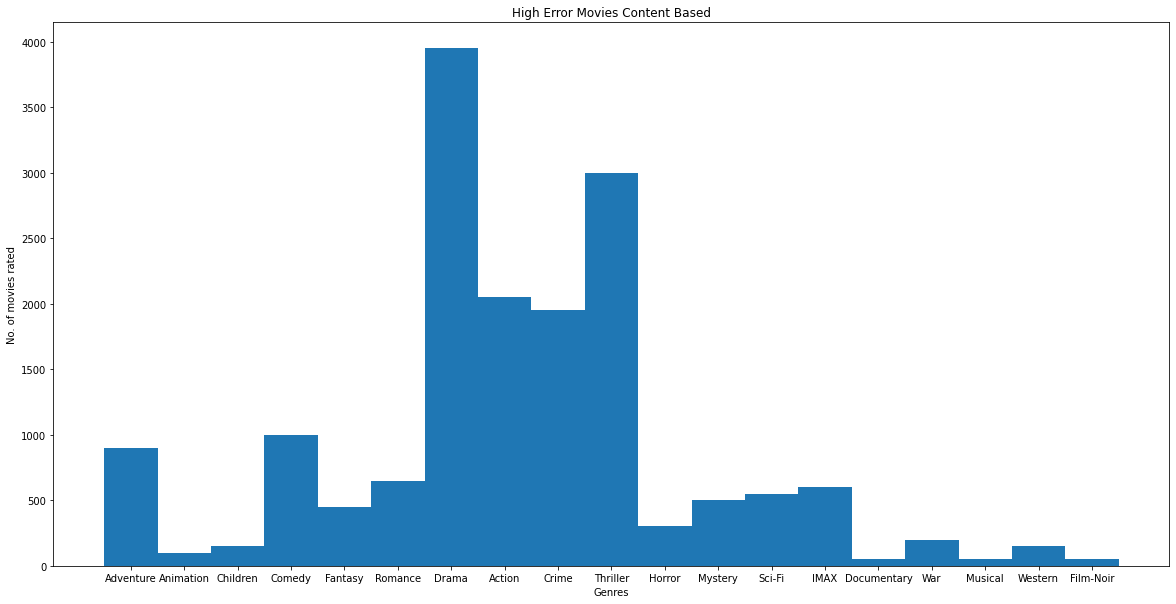

In [ ]:
fig = plt.figure(figsize = (20, 10)) 
  
# creating the bar plot 
plt.bar(unique_genres, genre_frequencies_test,   
        width = 1) 
  
plt.xlabel("Genres") 
plt.ylabel("No. of movies rated") 
plt.title("High Error Movies Content Based") 
plt.show()


KS two sample test:

We chose to use the KS two sample test because it is a non-parametric distribution free test; meaning we can use it to compare if two samples come from the same distribution without making any assumptions about the distribution. We chose to measure the distribution on genre because the genre feature plays a big role in ou recommender system, it is less sparse than the tags thus, and more informative than the year.

-A sample in our case is number of user ratings of movies per genre
-In genre_freqeuncies_test we have a sample movies from our test dataset whereby our recommender system incorrectly recommended movies by a margin geater than 0.5. We can change this value in the cell where we explore the napolean dynamite problem.

-null hypothesis: our two values are from the same distribution (there is no

-napolean dynamite effect occuring at our sample for a set margin of error)

-alternative hypothesis: our two values are from different distributions and 
Our recommender system is experiencing the napolean dynamite effect if our  value is less than 0.05 than at the 90% level of significance we have enough evidence to reject the null hypothesis. 
Else we do not have enough evidence to reject the null hypothesis.

In [ ]:
display(stats.ks_2samp(genre_frequencies_recent_df, genre_frequencies_test))

Ks_2sampResult(statistic=1.0, pvalue=5.6584667505013764e-11)

#Hybrid Algorithm using User-User and Content based

In [ ]:
# First we will select a subset of the dataframe the subset_rating_recent_df
subset_ratings_df_recent.head(5) 

In [ ]:
selected_user = select_a_user(subset_ratings_df_recent)

# Now we need two dataframes, one with the user's rated movies, one without
# random_user_ratings = subset_ratings_df_recent[(subset_ratings_df_recent["user"] == selected_user)]
# random_user_unrated = subset_ratings_df_recent[(subset_ratings_df_recent["user"] != selected_user)]
random_user_ratings, random_user_unrated = get_user_rated_and_unrated_movies(selected_user, ratings_df, movies_df)
print(f"User {selected_user} rated {len(random_user_ratings)} movies and {len(random_user_unrated)} are still unrated")


# Generate 50 recommendations for the random user
user_user = UserUser(15, min_nbrs=2)  # Minimum (3) and maximum (15) number of neighbors to consider
recsys = Recommender.adapt(user_user)
recsys.fit(subset_ratings_df_recent)
selected_movies_useruser = recsys.recommend(selected_user, 50)
selected_movies_useruser = selected_movies_useruser.join(movies_df['title'], on='item')
selected_movies_useruser = selected_movies_useruser.join(movies_df['tags'], on='item')
selected_movies_useruser = selected_movies_useruser.join(movies_df['genres'], on='item')
selected_movies_useruser = selected_movies_useruser.join(movies_df['year norm'], on='item')
selected_movies_useruser.head(5)

In [ ]:
# For the second part of this hybrid algorithm we will use the Content Based algorithm
# The final list of recommended movies will be a subset of the movies recommended by the UserUser algorithm

#################### Pas besoin des Kfold ############################################
# Juste predire des score avec le fit_transorm rien de plus

y_train = random_user_ratings['rating']
x_train = random_user_ratings.drop(['rating'],axis=1)
x_prediction = selected_movies_useruser

vectorizer_tags = CountVectorizer()
x_train_tags = vectorizer_tags.fit_transform(random_user_ratings['tags'])
vectorizer_genres = CountVectorizer()
x_train_genres = vectorizer_genres.fit_transform(random_user_ratings['genres'])
year_value = sp.csr_matrix((random_user_ratings['year norm'])).transpose()

final_x_train = sp.hstack((x_train_tags, x_train_genres, year_value))  
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(final_x_train, y_train)

x_prediction_tags = vectorizer_tags.transform(x_prediction['tags'])
x_prediction_genres = vectorizer_genres.transform(x_prediction['genres'])
year_values =sp.csr_matrix((x_prediction['year norm'])).transpose()

final_x_prediction = sp.hstack((x_prediction_tags, x_prediction_genres, year_values))
y_prediction = neigh.predict(final_x_prediction)
x_prediction['predicted rating'] = y_prediction
x_prediction.sort_values(by=['predicted rating'], ascending = False)
x_prediction.head()

################################################################

#Measuring diversity across diferent algorithms.
In order to measure it we need to define a similarity metric.
This similarity metric will compare two movies and will give points for every genre in common  as well as points for the same tag (tag hit will score more points as tags are, in general, more specific than genres)

It still needs to be merged with the rest of the code

In [ ]:
def similarity_pairwise(movie_id_1, movie_id_2, movies_df):
  """
  movies_df is the movies dataframe containing tags and genres after normalization and preproccessing 
  where the index represents the movie id, as sone previously in this notebook.

  """
  #first estimate how many hits we have for the tags
  tags1= movies_df.loc[movie_id_1, 'tags']
  tags2= movies_df.loc[movie_id_2, 'tags']
  nr_tag_hits = len(list(set(tags1).intersection(set(tags2))))
  nr_tag_total_added = len(list(set(tags2))) + len(list(set(tags1)))


  
  #second, we estimate how many hits we have for the genres
  genres1= movies_df.loc[movie_id_1, 'genres']
  genres2= movies_df.loc[movie_id_2, 'genres']
  nr_genre_hits = len(list(set(genres1).intersection(set(genres2))))
  nr_genres_total_added = len(list(set(genres1))) + len(list(set(genres2)))
  
  
  #now compute similarity by weighted sum
  weight_tag= 1/3
  weight_genre = 2/3
  #print('nr_tag_hits: ',nr_tag_hits, '  nr_tag_total:',nr_tag_total, '  nr_genre_hits:', nr_genre_hits)

  if nr_tag_total_added==0:
    nr_tag_total_added=1 #to avoid division by 0. result will still be 0
  if nr_genres_total_added==0:
    nr_genres_total_added=1
  
  similarity =  weight_tag* 2*nr_tag_hits/nr_tag_total_added + weight_genre * 2*nr_genre_hits/nr_genres_total_added
  #print('similarity: ', similarity)
  return similarity

def similarity_rec_list(recom_list_1, movies_df):
  sim_list_1 = 0
    
  nr_ev=0
    
  for i in range(len(recom_list_1)):
      for j in range(len(recom_list_1[i+1:])):
          if j != i:
              sim_list_1+= similarity_pairwise(recom_list_1[i], recom_list_1[j], movies_df)
              nr_ev+=1
  
  return sim_list_1/nr_ev
  



In [ ]:
num_recs = 10  # Number of recommendations to generate
user_user = UserUser(5, min_nbrs=2)  # Minimum (3) and maximum (15) number of neighbors to consider
recsys = Recommender.adapt(user_user)
recsys.fit(subset_ratings_df_recent)

selected_user = select_a_user(subset_ratings_df_recent)#full ratings
selected_movies_useruser = recsys.recommend(selected_user, 10) # generate 10 recommendations for the selected user 
selected_movies_useruser = selected_movies_useruser.join(movies_df['title'], on='item')
display(selected_movies_useruser)
print(len(selected_movies_useruser))

,item,score,title
0,6475,4.815911,Opportunity Knocks (1990)
1,5244,4.062947,Shogun Assassin (1980)
2,5287,4.041666,"After Dark, My Sweet (1990)"
3,4301,3.819977,Calle 54 (2000)
4,5605,3.738171,Ratcatcher (1999)
5,127021,3.696812,Rewind This! (2013)
6,129241,3.648316,Tis kakomoiras (1963)
7,89083,3.626910,"Great White Silence, The (1924)"
8,66870,3.622872,Everlasting Moments (Maria Larssons eviga ögon...
9,128981,3.583871,Music for One Apartment and Six Drummers (2001)


10


In [ ]:
#We test our methods, let´s calculate the similarity pairwise first
movie_id_1 = 5244
movie_id_2 = 128981
recom_list_1=list(selected_movies_useruser[:5]['item'])
recom_list_2=list(selected_movies_useruser[5:]['item'])

print(recom_list_1)
print(similarity_pairwise(movie_id_1, movie_id_2, movies_df))
print(similarity_rec_list(recom_list_1, movies_df))

[111878, 53788, 70295, 4301, 33270]
0.25146198830409355
0.28113553113553114


### Evaluating similarity
We run our algorithms to get recommendations list for significant enough number of users and compare it

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None 

ratings_df_to_use= subset_ratings_df_recent
total_sim_cf=0
total_sim_content=0
total_sim_hybrid=0
recom_size=10
NUMBER_OF_USERS_TO_TEST = 200; #this will be how many users we model for and do a k-fold test
usersToTest = select_muliple_users(ratings_df_to_use,NUMBER_OF_USERS_TO_TEST);
for user in usersToTest:

  rated_movies_df, unrated_movies_df = get_user_rated_and_unrated_movies(user, ratings_df_to_use, movies_df)
  # Initializing the lists where we will keep the precision, recall and fscore related to each fold

  y_train = rated_movies_df['rating']
  X_train = rated_movies_df.drop(['rating'],axis=1)
  X_predict = unrated_movies_df
  # Iterate over the folds


  #Produce a list of recommendations using content based algorithm

  #vectorizer_tags = CountVectorizer()
  vectorizer_tags = TfidfVectorizer()
  X_train_tags = vectorizer_tags.fit_transform(X_train['tags'])
  #vectorizer_genres = CountVectorizer()
  vectorizer_genres = TfidfVectorizer()
  X_train_genres = vectorizer_genres.fit_transform(X_train['genres'])

  year =sp.csr_matrix((X_train['year norm'])).transpose()
  X_train_all= sp.hstack((X_train_tags, X_train_genres, year ))  
  
  neigh = KNeighborsRegressor(n_neighbors=5) #default similarity metric is euclidean
  neigh.fit(X_train_all, y_train)
  
  X_predict_tags = vectorizer_tags.transform(X_predict['tags'])
  X_predict_genres = vectorizer_genres.transform(X_predict['genres'])
  X_predict_all = sp.hstack((X_predict_tags,X_predict_genres))
  year =sp.csr_matrix((X_predict['year norm'])).transpose()
  X_predict_all = sp.hstack((X_predict_all,year))

  y_pred = neigh.predict(X_predict_all) # Evaluates the predictions of the classifier
  X_predict['predicted rating'] = y_pred
  X_predict = X_predict.sort_values(by=['predicted rating'], ascending = False)
  content_algo_rec_list = list(X_predict['item'])[:recom_size]
  #print(y_pred)
  #print(X_predict.head())
  #print(content_algo_rec_list)


  #Now for that same user produce a recommendation using the collaborative filtering algorithm
  num_recs = 10  # Number of recommendations to generate
  user_user = UserUser(15, min_nbrs=2)  # Minimum (3) and maximum (15) number of neighbors to consider
  recsys = Recommender.adapt(user_user)
  recsys.fit(ratings_df_to_use)

  selected_movies_useruser = recsys.recommend(user, recom_size) # generate 10 recommendations for the selected user 
  #selected_movies_useruser = selected_movies_useruser.join(movies_df['title'], on='item')
  cf_rec_list = list(selected_movies_useruser['item'])
  #print(cf_rec_list)


  #Now run the hybrid algorithm:
  unrated_movies_df= unrated_movies_df.drop(['predicted rating'], axis=1)
  #start by computing a list of 50 elements using the cf algorithm
  num_recs = 50  # Number of recommendations to generate
  user_user = UserUser(15, min_nbrs=2)  # Minimum (3) and maximum (15) number of neighbors to consider
  recsys = Recommender.adapt(user_user)
  recsys.fit(ratings_df_to_use)
  selected_movies_useruser = recsys.recommend(user, recom_size)
  #print(selected_movies_useruser)


  #now run the content based one on those reduced ones
  
  y_train = rated_movies_df['rating']
  X_train = rated_movies_df.drop(['rating'],axis=1)
  
  
  #print('unrated_movies_df[item]', unrated_movies_df['item'])
  #print('selected_movies_useruser[item]', selected_movies_useruser['item'])
  filtered_items = list(selected_movies_useruser['item'])
  
  X_predict = unrated_movies_df[unrated_movies_df['item'].isin(filtered_items)]



  #Produce a list of recommendations using content based algorithm

  #vectorizer_tags = CountVectorizer()
  vectorizer_tags = TfidfVectorizer()
  X_train_tags = vectorizer_tags.fit_transform(X_train['tags'])
  #vectorizer_genres = CountVectorizer()
  vectorizer_genres = TfidfVectorizer()
  X_train_genres = vectorizer_genres.fit_transform(X_train['genres'])

  year =sp.csr_matrix((X_train['year norm'])).transpose()
  X_train_all= sp.hstack((X_train_tags, X_train_genres, year ))  
  
  neigh = KNeighborsRegressor(n_neighbors=5) #default similarity metric is euclidean
  neigh.fit(X_train_all, y_train)
  
  X_predict_tags = vectorizer_tags.transform(X_predict['tags'])
  X_predict_genres = vectorizer_genres.transform(X_predict['genres'])
  X_predict_all = sp.hstack((X_predict_tags,X_predict_genres))
  year =sp.csr_matrix((X_predict['year norm'])).transpose()
  X_predict_all = sp.hstack((X_predict_all,year))
  y_pred = neigh.predict(X_predict_all) # Evaluates the predictions of the classifier
  X_predict['predicted rating'] = y_pred
  X_predict = X_predict.sort_values(by=['predicted rating'], ascending = False)
  hybrid_algo_rec_list = list(X_predict['item'])[:recom_size]


  #compute similarities
  #PLEASE BE AWARE THAT BOTH LIST MUST HAVE THE SAME LENGTH
  sim_content = similarity_rec_list(content_algo_rec_list, movies_df)
  sim_cf = similarity_rec_list(cf_rec_list, movies_df)
  sim_hybrid = similarity_rec_list(hybrid_algo_rec_list, movies_df)
  #print('sim content: ', sim_content)
  #print('sim cf: ', sim_cf)
  total_sim_cf+= sim_cf
  total_sim_content+= sim_content
  total_sim_hybrid+= sim_hybrid

total_sim_cf=total_sim_cf/NUMBER_OF_USERS_TO_TEST
total_sim_content=total_sim_content/NUMBER_OF_USERS_TO_TEST
total_sim_hybrid=total_sim_hybrid/NUMBER_OF_USERS_TO_TEST
print('total similarity observed:')
print('Content based algorithm: ', total_sim_content)
print('Collaborative filtering algorithm: ', total_sim_cf)
print('Hybrid algorithm: ',  total_sim_hybrid)

  


total similarity observed:
Content based algorithm:  0.6342408444309988
Collaborative filtering algorithm:  0.5377192762551206
Hybrid algorithm:  0.5442365810792442


# Aggregation algorithms for groups of users

Summary:

**Selection of a group in our dataset**
We will select different groups.
 

1.   A random group of 2 users
2.   A random group of 5 users

Then for our algorithms we will assume the group of 2 people represents a couple that have been together for a long time.

We will also assume that the group of 5 people represents 

*   A group of friends
*   A weak relationship group
*   A family with 2 parents and 3 kids

If we had data on demographics we could train our models in such situations, since we do not.

We will try differnet aggregations strategies depending on what our groups represent

The groups will be selected randomly.




**Aggregation Strategies for Group Recommenders:**

The aggregations strategies will be different for each of the groups. We will follow the work of 'Gartrell 2010', he proposes to use different aggregation strategies for different groups in terms of internal strength.


1.   Close relationship-> most pleasure
2.   weak relationships groups-> Least Misery
3.   average group of friends -> average (consensus based) 
4.   Family-> weighted average (prioritizes children opinion while it gives lower weights to adults)



We will study how each different approach behaves for each type of aggregation. 
Then we will motivate why each slgorithm should be better in each case

**Explanations for Group Recommenders **
We will also provide explanations for our recommendations.

It is worth mentioning that instead of the average aggregation strategy, multiplicative aggregation strategy could have been chosen. However it was not chosen due to the fact that users like short and simple explanations. The user would more easily understand the average strategy than the multiplicative strategy. Helping users understand our choice will build their trust in the system, which is something we would like to achieve


### Selecting users: Random group
For simplicity we limit ourselves to selecting users that have more than 200 movies rated.

As explained above we will select a group of two users that represents a couple on a relationship

In [ ]:
def select_a_group(group_size):
  users_ratings = ratings_df.groupby(['user']).count()
  selected = users_ratings['rating'] > 200
  selected_users = users_ratings.loc[selected]
  random_selected = selected_users.sample(n=group_size) # sample() returns now n random rows from the dataframe. The returned object is a dataframe with five rows. 
  select_column_df = random_selected.reset_index()['user'] # reset_index() create a new index, and the userId became a column. Then, we can filter using the column name
  return list(select_column_df) # iloc select by index, since our dataframe only has one row we read it from the index 0
  

Let us assume we want to recommend to both groups a list of 10 movies that nobody in the group has seen yet. We first need to determine the list of possible candidates. For simplicity, we will only consider movies for which we more then 10 evaluations


In [ ]:
def select_group_movies(selected_group):
  group_ratings = ratings_df.loc[ratings_df['user'].isin(selected_group)]
  all_movies = set(movies_df.index.tolist())
  num_ratings_df = ratings_df.groupby(['item']).count()
  considered_movies = set(num_ratings_df.loc[num_ratings_df['user'] > 10].reset_index()['item'])

  group_seen_movies = set(group_ratings['item'].tolist())
  group_unseen_movies = considered_movies - group_seen_movies
  group_unseen_df = pd.DataFrame(list(itertools.product(selected_group, group_unseen_movies)), columns=['user', 'item'])
  group_unseen_df = predict_rec(group_unseen_df)

  return group_unseen_df
  #print(len(all_movies))
  #print(len(considered_movies))
  #print(len(group_seen_movies))
  #print(len(group_unseen_movies))

Now, we need to evaluate individuals' preverences for the unseen movies. To do so, we use the Lenskit library. We will use  CF recommender used in the previous example, (user collaborative filter).  To generate the Dataframe with user-item pairs to pass as input in the predict function, we use the product method of the itertools library, which takes as imput two lists and returns all the possible combinations between elements of the two lists. This is passed as input for the Dataframe constructor, which will then generate a Dataframe containing a pair on each row.

In [ ]:
def predict_rec(group_unseen_df):
  user_user = UserUser(15, min_nbrs=3)  # Minimum (3) and maximum (15) number of neighbors to consider
  recsys = Recommender.adapt(user_user)
  recsys.fit(ratings_df)
  group_unseen_df['predicted_rating'] = recsys.predict(group_unseen_df)
  return group_unseen_df

### Aggregation Strategies for Group Recommenders

As mentioned before, the aggregation strategies will depend on the group that is using the system.

**For the group of 2 users, which is a couple in love, we will use the least most pleasure aggregation strategy**

**Most pleasure strategy**
The Most Pleasure strategy considers as group rating the maximum of all the individuals ratings. Then, the recommended items are the one scoring the best with such group rating. Again, We can easily implement it grouping our group_unseen_df Dataframe by item, and then computing the max.


In [ ]:
#most pleasure
def most_pleasure(selected_group):
  group_unseen_df = select_group_movies(selected_group)
  max_ratings_df = group_unseen_df.groupby('item')['predicted_rating']
  group_unseen_df['max_rating'] = max_ratings_df.transform('max')
  group_unseen_df = group_unseen_df.join(movies_df['title'], on='item', how='left', lsuffix='_left')
  group_unseen_df = group_unseen_df.sort_values(by="max_rating", ascending=False).reset_index()[['user', 'item', 'title', 'predicted_rating', 'max_rating']]
  return(group_unseen_df)

**For the group of 5 users, representing a weak relationship type, we will use the least misery strategy.**

**Least Misery strategy**
The Least Misery strategy considers as group rating the minimum of all the individuals ratings. Then, the recommended items are the one scoring the best with such group rating. As we did before, we can implement it grouping our group_unseen_df Dataframe by item, and then computing the min

In [ ]:
def least_misery(group_size):
  group_unseen_df = select_group_movies(selected_group)
  min_ratings_df = group_unseen_df.groupby('item')['predicted_rating']
  group_unseen_df['min_rating'] = min_ratings_df.transform('min')
  group_unseen_df = group_unseen_df.join(movies_df['title'], on='item', how='left', lsuffix='_left')
  group_unseen_df = group_unseen_df.sort_values(by="min_rating", ascending=False).reset_index()[['user', 'item', 'title', 'predicted_rating', 'min_rating']]
  return(group_unseen_df)

**For the group of 5 users, representing a group of friends, we will use the average strategy.**

**Average strategy**
The Average strategy rates every item using the average of the ratings of each user for that movie

In [ ]:
def avg_strategy(group_size):
  group_unseen_df = select_group_movies(selected_group)
  avg_ratings_df = group_unseen_df.groupby('item')['predicted_rating']
  group_unseen_df['avg_rating'] = avg_ratings_df.transform('mean')
  group_unseen_df = group_unseen_df.join(movies_df['title'], on='item', how='left', lsuffix='_left')
  group_unseen_df = group_unseen_df.sort_values(by='avg_rating', ascending=False).reset_index()[['user', 'item', 'title', 'predicted_rating', 'avg_rating']]
  return(group_unseen_df)
  

**The First Hybrid Strategy:** Using a mixture of No Misery, Least Misery, and Most Pleasure

In [ ]:
def hybrid_1(group_size):
  group_unseen_df = select_group_movies(selected_group)
  
  #add columns of min and max
  min_ratings_df = group_unseen_df.groupby('item')['predicted_rating']
  group_unseen_df['min_rating'] = min_ratings_df.transform('min')
  max_ratings_df = group_unseen_df.groupby('item')['predicted_rating']
  group_unseen_df['max_rating'] = max_ratings_df.transform('max')
  
  threshold = 2
  #remove all movies that the users would absolutely hate (based on threshold)
  hybrid_1_df = group_unseen_df.loc[group_unseen_df['min_rating'] > threshold]

  #add least rating and highest rating
  hybrid_1_df['combined_rating'] = group_unseen_df.apply(lambda row: row.min_rating + row.max_rating, axis=1)
  hybrid_1_df = hybrid_1_df.join(movies_df['title'], on='item', how='left', lsuffix='_left')
  hybrid_1_df = hybrid_1_df.sort_values(by='combined_rating', ascending=False).reset_index()[['user', 'item', 'title', 'predicted_rating', 'combined_rating']]
  return(hybrid_1_df)


**The second Hybrid Strategy:** Using the fairness strategy and using the average in case of ties

In [ ]:
def hybrid_2(group_size):
  group_unseen_df = select_group_movies(selected_group)

  #add avg column
  avg_ratings_df = group_unseen_df.groupby('item')['predicted_rating']
  group_unseen_df['avg_rating'] = avg_ratings_df.transform('mean')
  
  hybrid_2_df = pd.DataFrame()
  n = 10 #number of recommendations
  while(len(hybrid_2_df)<=(n-len(selected_group))):
    for user in selected_group:
      if(len(hybrid_2_df)<n):
        select_user_ratings_df = group_unseen_df.loc[group_unseen_df['user'] == user]
        select_user_ratings_df = select_user_ratings_df.join(movies_df['title'], on='item', how='left', lsuffix='_left')
        select_user_ratings_df = select_user_ratings_df.sort_values(by=['predicted_rating', 'avg_rating'], ascending=[False, False]).reset_index()[['user', 'item', 'title', 'predicted_rating', 'avg_rating']]
        select_user_ratings_df['count'] = select_user_ratings_df['predicted_rating'].map(select_user_ratings_df['predicted_rating'].value_counts())
        
        i = 0
        most_pleasure = select_user_ratings_df.iloc[i]
        if(len(hybrid_2_df)>0):
          if(most_pleasure['title'] in hybrid_2_df.title.values):  #check for more than 2 rounds
            most_pleasure = select_user_ratings_df.iloc[[++i]]
        hybrid_2_df = hybrid_2_df.append(most_pleasure)
  hybrid_2_df = hybrid_2_df.reset_index()[['user', 'item', 'title', 'predicted_rating', 'avg_rating']]
  return(hybrid_2_df)

**Explanations for Group Recommenders**
 For the Least Misery and Most Pleasure strategies we will use use social-choice based explanations as defined in Barile et al., 2021.
 For the average explanation we will use a generic formulation.

**Least Misery:** "i_k has been recommended to the group since no group members has a real problem with it."

**Most Pleasure:** "i_k has been recommended to the group since it achieves the highest of all individual group members."

**Average:** "i_k has been recommended to the group since it achieves the highest average rating out of all other items".




In [ ]:
explanations = {
    "AVG" : "<item> has been recommended to the group since it achieves the highest total average rating.\n",
    "LMS" : "<item> has been recommended to the group since no group members has a real problem with it.\n",
    "MPL" : "<item> has been recommended to the group since it achieves the highest of all individual group members.\n",
    "HYB1" : "<item> has been recommended to the group since nobody in the group really hated it and it achieved a rating of <rating>, the highest rating when combining the highest and lowest rating for it amongst all individual group members.\n",
    "HYB2" : "<item> has been recommended to the group since <user1> had a chance to pick this time and <user2> gets to pick the next time.\n",
}

group_size = 5
selected_group = select_a_group(group_size)
most_pleasure_df = most_pleasure(selected_group)
least_misery_df = least_misery(selected_group)
avg_df = avg_strategy(selected_group)
hybrid_1_df = hybrid_1(selected_group)
hybrid_2_df = hybrid_2(selected_group)


# Present explanations for the first item of each strategy
movie_title = least_misery_df['title'].iloc[0]
print("Recommendation: " + movie_title.title())
print(explanations["LMS"].replace("<item>", "The movie \"" + movie_title.title() + "\""))

movie_title = most_pleasure_df['title'].iloc[0]
print("Recommendation: " + movie_title.title())
print(explanations["MPL"].replace("<item>", "The movie \"" + movie_title.title() + "\""))

movie_title = avg_df['title'].iloc[0]
print("Recommendation: " + movie_title.title())
print(explanations["AVG"].replace("<item>", "The movie \"" + movie_title.title() + "\""))

movie_title = hybrid_1_df.iloc[0]
print("Recommendation: " + movie_title.title)
explanations["HYB1"] = explanations["HYB1"].replace("<rating>", str(movie_title.combined_rating))
print(explanations["HYB1"].replace("<item>", "The movie \"" + movie_title.title + "\""))

movie_title = hybrid_2_df['title'].iloc[0]
user1 = hybrid_2_df['user'].iloc[0]
user2 = hybrid_2_df['user'].iloc[1]
print("Recommendation: " + movie_title.title())
explanations["HYB2"] = explanations["HYB2"].replace("<item>", "The movie \"" + movie_title)
explanations["HYB2"] = explanations["HYB2"].replace("<user1>",  "User " + str(int(user1)))
print(explanations["HYB2"].replace("<user2>", "User " + str(int(user2))))




/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
Numba is using threading layer omp - consider TBB
BLAS using multiple threads - can cause oversubscription
found 2 potential runtime problems - see https://boi.st/lkpy-perf
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Recommendation: Cosmos (1980)
The movie "Cosmos (1980)" has been recommended to the group since no group members has a real problem with it.

Recommendation: Cosmos (1980)
The movie "Cosmos (1980)" has been recommended to the group since it achieves the highest of all individual group members.

Recommendation: Shadows Of Our Forgotten Ancestors (Tini Zabutykh Predkiv) (1964)
The movie "Shadows Of Our Forgotten Ancestors (Tini Zabutykh Predkiv) (1964)" has been recommended to the group since it achieves the highest total average rating.

Recommendation: Cosmos (1980)
The movie "Cosmos (1980)" has been recommended to the group since nobody in the group really hated it and it achieved a rating of 9.817986858157031, the highest rating when combining the highest and lowest rating for it amongst all individual group members.

Recommendation: Sunrise: A Song Of Two Humans (1927)
The movie "Sunrise: A Song of Two Humans (1927) has been recommended to the group since User 41713 had a chance to 

 **EVALUATING GROUP RS**


*   Error metric:
*   Coverage:



In [ ]:
mean_error_group_dict = {'Most Pleasure':0, 'Least Misery':0, 'Average':0, 'Hybrid 1':0, 'Hybrid 2':0}
mean_squared_error_group_dict = {'Most Pleasure':0, 'Least Misery':0, 'Average':0, 'Hybrid 1':0, 'Hybrid 2':0}

group_size = 5
  
n = 50

for i in range(n):
  selected_group = select_a_group(group_size)
  error_threshold = avg_strategy(selected_group).iloc[0]['avg_rating']

  most_pleasure_df = most_pleasure(selected_group)
  most_pleasure_movie = most_pleasure_df.iloc[0]['item']
  most_pleasure_movie_df = most_pleasure_df.loc[most_pleasure_df['item'] == most_pleasure_movie]
  mp_avg_rating = most_pleasure_movie_df['predicted_rating'].mean()
  most_pleasure_error = abs(error_threshold - mp_avg_rating)
  mean_error_group_dict['Most Pleasure'] = mean_error_group_dict['Most Pleasure']+most_pleasure_error
  mean_squared_error_group_dict['Most Pleasure'] = mean_squared_error_group_dict['Most Pleasure']+ np.square(most_pleasure_error)

  least_misery_df = least_misery(selected_group)
  least_misery_movie = least_misery_df.iloc[0]['item']
  least_misery_movie_df = least_misery_df.loc[least_misery_df['item'] == least_misery_movie]
  lm_avg_rating = least_misery_movie_df['predicted_rating'].mean()
  least_misery_error = abs(error_threshold - lm_avg_rating)
  mean_error_group_dict['Least Misery'] = mean_error_group_dict['Least Misery']+least_misery_error
  mean_squared_error_group_dict['Least Misery'] = mean_squared_error_group_dict['Least Misery']+ np.square(least_misery_error)

  avg_df = avg_strategy(selected_group)
  avg_df_movie = avg_df.iloc[0]['item']
  avg_movie_df = avg_df.loc[avg_df['item'] == avg_df_movie]
  avg_avg_rating = avg_movie_df['predicted_rating'].mean()
  avg_error = abs(error_threshold - avg_avg_rating)
  mean_error_group_dict['Average'] = mean_error_group_dict['Average']+avg_error
  mean_squared_error_group_dict['Average'] = mean_squared_error_group_dict['Average']+ np.square(avg_error)

  hybrid_1_df = hybrid_1(selected_group)
  hybrid_1_movie = hybrid_1_df.iloc[0]['item']
  hybrid_1_movie_df = hybrid_1_df.loc[hybrid_1_df['item'] == hybrid_1_movie]
  hybrid_1_avg_rating = (hybrid_1_movie_df['predicted_rating'].mean())
  hybrid_1_error = abs(error_threshold - hybrid_1_avg_rating)
  mean_error_group_dict['Hybrid 1'] = mean_error_group_dict['Hybrid 1']+hybrid_1_error
  mean_squared_error_group_dict['Hybrid 1'] = mean_squared_error_group_dict['Hybrid 1']+ np.square(hybrid_1_error)

  hybrid_2_df = hybrid_2(selected_group)
  hybrid_2_movie = hybrid_2_df.iloc[0]['item']
  hybrid_2_movie_df = hybrid_2_df.loc[hybrid_2_df['item'] == hybrid_2_movie]
  hybrid_2_avg_rating = hybrid_2_movie_df['predicted_rating'].mean()

  hybrid_2_error = abs(error_threshold - hybrid_2_avg_rating)
  mean_error_group_dict['Hybrid 2'] = mean_error_group_dict['Hybrid 2']+hybrid_2_error
  mean_squared_error_group_dict['Hybrid 2'] = mean_squared_error_group_dict['Hybrid 2']+ np.square(hybrid_2_error)

for key in mean_error_group_dict:
  mean_error_group_dict[key] = mean_error_group_dict[key]/n
  mean_squared_error_group_dict[key] = mean_squared_error_group_dict[key]/n

print(mean_error_group_dict)
print(mean_squared_error_group_dict)


    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

{'Most Pleasure': 0.24878546058103812, 'Least Misery': 0.12407563637866653, 'Average': 3.019806626980426e-16, 'Hybrid 1': 0.06003820691026182, 'Hybrid 2': 0.30636920657021366}
{'Most Pleasure': 0.115440305134172, 'Least Misery': 0.047330912551754166, 'Average': 2.6821270777514403e-31, 'Hybrid 1': 0.01151054405328468, 'Hybrid 2': 0.15004467280365447}


#  MOVED DOWN FOR REFACTOR, WAS BEFORE KFOLD- WAS IN CONTENT ALGORITHM We use vectorizer to extract features from tags and genres. They will all be given equal weights in our calculations.

In [ ]:

vectorizer_tags = CountVectorizer()
X_tags = vectorizer_tags.fit_transform(rated_movies_df['tags'])
vectorizer_genres = CountVectorizer()
X_genres = vectorizer_genres.fit_transform(rated_movies_df['genres'])


year =sp.csr_matrix((rated_movies_df['year norm'])).transpose()


X_all = sp.hstack((X_tags,X_genres))  # concatenating both sparse matrices
X_all= sp.hstack((X_all, year ))  
print(X_tags.shape)
print(X_genres.shape)
print(X_all.shape)




(279, 5819)
(279, 20)
(279, 5840)


### Now we train a regressor
We use KNN algorithm

In [ ]:

y = rated_movies_df['rating']
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_all, y)

KNeighborsRegressor()

Using the trained model we calculate the recommendations for the given user

In [ ]:

X_tags_unrated = vectorizer_tags.transform(unrated_movies_df['tags'])
X_genres_unrated = vectorizer_genres.transform(unrated_movies_df['genres'])
X_unrated_all = sp.hstack((X_tags_unrated,X_genres_unrated))
year =sp.csr_matrix((unrated_movies_df['year norm'])).transpose()
X_unrated_all = sp.hstack((X_unrated_all,year))
#X_unrated_all= sp.hstack((X_unrated_all, unrated_movies_df['year norm']))  
print(X_tags_unrated.shape)
print(X_genres_unrated.shape)
print(X_unrated_all.shape)

y_unrated = neigh.predict(X_unrated_all)
print(y_unrated.shape)

(26999, 5819)
(26999, 20)
(26999, 5840)
(26999,)


Finally, we can combine the predicted ratings with the information in the unrated_movies Dataframe, order the movies by predicted ratings, and determine the best 10 movies to recommend to the user.

In [ ]:
unrated_movies_df['predicted_ratings_KNN'] = y_unrated
unrated_movies_df_KNN_ordering = unrated_movies_df.sort_values(by='predicted_ratings_KNN', ascending=False)
display(unrated_movies_df_KNN_ordering.head(10))


,item,title,genres,tags,year,year norm,predicted_rating,predicted_ratings_KNN
item,,,,,,,,
52462,52462,Aqua Teen Hunger Force Colon Movie Film for Th...,Action Adventure Animation Comedy Fantasy Myst...,Neil_Peart disappointing beginning Bruce_Campb...,2007.0,0.935484,4.1,4.1
1396,1396,Sneakers (1992),Action Comedy Crime Drama Sci-Fi,comedy black_comedy computer btaege computer_c...,1992.0,0.814516,4.1,4.1
59615,59615,Indiana Jones and the Kingdom of the Crystal S...,Action Adventure Comedy Sci-Fi,Indiana_Jones comedy McCarthyism Ruined_the_fr...,2008.0,0.943548,4.1,4.1
40339,40339,Chicken Little (2005),Action Adventure Animation Children Comedy Sci...,dodgeball story Zach_Braff cute Children Disne...,2005.0,0.919355,4.1,4.1
81564,81564,Megamind (2010),Action Animation Children Comedy Sci-Fi IMAX,Tru_3_D comedy Watched Tom_McGrath heel_face_t...,2010.0,0.959677,4.1,4.1
26513,26513,"Ice Pirates, The (1984)",Action Adventure Comedy Sci-Fi,spaceflight dystopia time_travel cult_film rob...,1984.0,0.750000,4.1,4.1
8633,8633,"Last Starfighter, The (1984)",Action Adventure Comedy Sci-Fi,70mm Betamax video_games cosy feel_good spacef...,1984.0,0.750000,4.1,4.1
3471,3471,Close Encounters of the Third Kind (1977),Adventure Drama Sci-Fi,70mm vision alien_invasion AFI_100 acting Tume...,1977.0,0.693548,4.0,4.0
3018,3018,Re-Animator (1985),Comedy Horror Sci-Fi,Stuart_Gordon Betamax Nudity__Full_Frontal_ ho...,1985.0,0.758065,4.0,4.0


In [ ]:
#explanation I still need to fix this
item= 1396
nr_nei=5
explanation_content_based(item, unrated_movies_df, movies_df,vectorizer_tags, vectorizer_genres, nr_nei)

in method


ValueError: ignored

In [ ]:

print(type(unrated_movies_df.loc[1396, 'tags']))
print(unrated_movies_df.loc[1396, 'tags'])


<class 'str'>
comedy black_comedy computer btaege computer_cracker NO_FA_GANES weak_ending phreaking Phil_Alden_Robinson River_Phoenix Stephen_Tobolowsky DVD_Video Ben_Kingsley Quirky conspiracy_theory hacking David_Strathairn surveillance caper stupid hacker spying Mary_McDonnell Funny_as_hell cryptography espionage Robert_Redford must_show Terrific_cast heist Sidney_Poitier blindness ensemble_cast Caper Dan_Aykroyd 


### Using words frequencies in plots like in the lab
Possible improvements: lemmatization, removal of stopwords, etc, take a look at the library nltk

We have no info on plots, we might have to do something about this! 

We get info on plots from: https://www.kaggle.com/jrobischon/wikipedia-movie-plots

The following code is obtained from the github provided by the teachers of the code. it is used for preproccessing

In [ ]:
plots_df = pd.read_csv(data_path+"/wiki_movie_plots_deduped.csv", engine='python') 
display(plots_df.head(10))

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
5,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab..."
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
8,1905,The Little Train Robbery,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Little_Train...,The opening scene shows the interior of the ro...
9,1905,The Night Before Christmas,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Night_Before...,Scenes are introduced using lines of the poem....


Compute a feature representation for the movie's contents (TF-IDF)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(rated_movies_df['Plot'])
print(X.shape)

KeyError: ignored

Train a regressor, computing of the predicted ratings for unrated movies, and recommending the movies with higher predicted ratings

In [ ]:
X_unrated = vectorizer.transform(unrated_movies_df['Plot'])
print(X_unrated.shape)
y_unrated = neigh.predict(X_unrated)
print(y_unrated.shape)

Evaluator of content based algorithm 

### Join movie.csv and rating.csv into movie_and_plots_df


1. Split title and year into two different columns

In [ ]:
def split_title_year(row):
  title_year = str(row['title']).strip() # strip removes the spaces at the beginning and end of the string
  year = title_year[-5:-1] # gives substring containing the year 

  # Check if substring is the year
  if year.isdigit():
    # Modify the title column
    title = title_year[:-6].strip()
    return int(year), title
  else:
    return 0, title_year.lower()

In [ ]:
movies_df[['year','title']] = movies_df.apply(split_title_year, axis = 1, result_type='expand')
display(movies_df.head(10))

,item,title,genres,year
item,,,,
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
2,2,Jumanji,Adventure|Children|Fantasy,1995
3,3,Grumpier Old Men,Comedy|Romance,1995
4,4,Waiting to Exhale,Comedy|Drama|Romance,1995
5,5,Father of the Bride Part II,Comedy,1995
6,6,Heat,Action|Crime|Thriller,1995
7,7,Sabrina,Comedy|Romance,1995
8,8,Tom and Huck,Adventure|Children,1995
9,9,Sudden Death,Action,1995


2. Remove duplicates (movies_df might have the same movie twice with different index/item number)

In [ ]:
count_movies = movies_df.groupby(['title','year']).count()
print(f'There are {len(count_movies)} movies in the dataframe')
res_movies_df = movies_df.drop_duplicates(subset='title', keep='first')
count_movies = res_movies_df.groupby(['title','year']).count()
print(f'After dropping there are {len(count_movies)} movies in the dataframe')
movies_df = res_movies_df

There are 27262 movies in the dataframe
After dropping there are 26213 movies in the dataframe


3. Preprocessing the Wikipedia Movies Plots dataset

In [ ]:
plots_df = pd.read_csv(data_path+"/wiki_movie_plots_deduped.csv")
plots_df['title'] = plots_df['Title'].str.strip()
plots_df = plots_df.rename(columns={'Release Year':'year','Plot':'plot'})
#Remove the Origin, Director, Cast, Genre (mostly unknown) and the link to the wiki page
plots_df = plots_df[['title','year','plot']]
display(plots_df.head(10))

,title,year,plot
0,Kansas Saloon Smashers,1901,"A bartender is working at a saloon, serving dr..."
1,Love by the Light of the Moon,1901,"The moon, painted with a smiling face hangs ov..."
2,The Martyred Presidents,1901,"The film, just over a minute long, is composed..."
3,"Terrible Teddy, the Grizzly King",1901,Lasting just 61 seconds and consisting of two ...
4,Jack and the Beanstalk,1902,The earliest known adaptation of the classic f...
5,Alice in Wonderland,1903,"Alice follows a large white rabbit down a ""Rab..."
6,The Great Train Robbery,1903,The film opens with two bandits breaking into ...
7,The Suburbanite,1904,The film is about a family who move to the sub...
8,The Little Train Robbery,1905,The opening scene shows the interior of the ro...
9,The Night Before Christmas,1905,Scenes are introduced using lines of the poem....


4. Removing duplicates in Wikipedia dataset

In [ ]:
count_movies = plots_df.groupby(['title','year']).count()
print(f'There are {len(count_movies)} movies in the wiki dataframe')
res_movies_df = plots_df.drop_duplicates(subset=['title','year'], keep='first')
count_movies = res_movies_df.groupby(['title','year']).count()
print(f'After dropping there are {len(count_movies)} movies in the dataframe')
plots_df = res_movies_df

There are 34572 movies in the wiki dataframe
After dropping there are 34572 movies in the dataframe


5. Merging the two datasets movies_df and plots_df

By merging both dataframes we will lose some movies, so the merged dataframe will not be movies_df but movies_and_plots_df 

In [ ]:
movies_and_plots_df = pd.merge(movies_df, plots_df, how='inner', left_on=['title','year'], right_on=['title','year'])
movies_and_plots_df = movies_and_plots_df[['item','title','year','genres','plot']]
#movies_and_plots_df = movies_and_plots_df.rename(columns={'plot_x':'plot'})
print("Numbers of movies after merging :" + str(movies_and_plots_df.shape[0]))
display(movies_and_plots_df.head(10))

Numbers of movies after merging :8015


,item,title,year,genres,plot
0,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,In a world where toys are living things who pr...
1,2,Jumanji,1995,Adventure|Children|Fantasy,"In 1869, near Brantford, New Hampshire, two br..."
2,3,Grumpier Old Men,1995,Comedy|Romance,The feud between Max (Walter Matthau) and John...
3,4,Waiting to Exhale,1995,Comedy|Drama|Romance,"""Friends are the People who let you be yoursel..."
4,5,Father of the Bride Part II,1995,Comedy,The film begins five years after the events of...
5,6,Heat,1995,Action|Crime|Thriller,"Neil McCauley, a career criminal, hires Waingr..."
6,7,Sabrina,1995,Comedy|Romance,Sabrina Fairchild is the young daughter of the...
7,8,Tom and Huck,1995,Adventure|Children,The movie opens with Injun Joe (Eric Schweig) ...
8,9,Sudden Death,1995,Action,Darren McCord (Jean-Claude Van Damme) is a Fre...
9,10,GoldenEye,1995,Action|Adventure|Thriller,"In 1986, at Arkhangelsk, MI6 agents James Bond..."


### Explanations for algorithms for individual users

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
def explanation_content_based(movie_id, unrated_movies_df, movies_df,vectorizer_tags, vectorizer_genres, nr_nei):
  """
movies_df is the movies dataframe containing tags and genres after normalization and 
preproccessing where the index represents the movie id, as sone previously in this notebook

the vectorizer needs to be the same as before
nr_nei : is the number of neighbours used int he content based algorithm
"""
  #first we need to get the nearest neighbours for that movie
  print('in method')
  tags_vec = vectorizer_tags.transform([unrated_movies_df.loc[movie_id, 'tags']])
  genres_vec = vectorizer_genres.transform([unrated_movies_df.loc[movie_id, 'genres']])
  year =sp.csr_matrix((rated_movies_df['year norm'])).transpose()


  X_all = sp.hstack((tags_vec, genres_vec))  # concatenating both sparse matrices
  X_all= sp.hstack((X_all, year ))  
  nbrs = NearestNeighbors(n_neighbors=nr_nei).transform(X_all)
  
  #second get what tags are in our recommended movie. This will be later on used to search for matches with the neigbours
  tags = movies_df.loc[movie_id, 'tags']
  mapped_tags = vectorizer_tags.transform(tags)
  
  genres = movies_df.loc[movie_id, 'tags']
  mapped_genres = vectorizer_vecs.transform(genres)
  mapped_genres_plus = [(x + len(vectorizer_genres.vocabulary_))  for x in mapped_genres]
  
      
  
  #once we have the nearest neigbours we get the intersection of tags and genres of the recommended movie with them
  hit_tags= [0] * len(mapped_tags)
  for idx in range(len(mapped_tags)):
      tag_idx = mapped_tags[idx]
      for neigh in nbrs:
          if neigh[tag_idx].todense()==1:
              hit_tags[idx]+=1
  
  #once we have the nearest neigbours we get the intersection of tags and genres of the recommended movie with them
  hit_genres= [0] * len(mapped_genres)
  for idx in range(len(mapped_genres)):
      genre_idx = mapped_genres[idx]
      for neigh in nbrs:
          if neigh[genre_idx].todense()==1:
              hit_genres[idx]+=1
  
  #now if a tag appears at least one time in the list of hits include it in the explanation. 
  #If a genre  has at least 2 hits include it in the explanation
  explanations_tags_vec = [tag for tag in hit_tags if tag>0]
  explanations_genres_vec = [genre for genre in hit_genres if genre>0]
  
  #now convert the vector back to its original form (text)
  sparse_input_tags = [1 if i in explanations_tags_vec else 0 for i in range(0, len(vectorizer_tags.vocabulary_))]
  tags_explain = vectorizer_tags.inverse_transform(sparse_input_tags)
  
  sparse_input_genres = [1 if i in explanations_genres_vec else 0 for i in range(0, len(vectorizer_genres.vocabulary_))]
  genres_explain = vectorizer_tags.inverse_transform(sparse_input_genres)
  
  
  
  print('this movie was recommended because it contains the following tags that you like:')
  for tag in tags_explain:
      print(tag)
  
  print('this movie was recommended because it contains the following genres that you like:')
  for genre in genres_explain:
      print(genre)
      
